# PARAMETERS 

In [6]:
model_architecture = 'mycifar'
tam_image = 224 #for fit generator
epochs = 100 #após 10 épocas sem melhorar pará (a usar callback)
batch_size = 32

num_imagens_test = 10
#just for tests (select max to train)
max_drImages = 20  #max 1020
max_dcImages = 0     #max 5000

In [3]:
from keras.models import Sequential
from keras.models import load_model
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Conv2D, Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.layers import Activation
from keras.constraints import maxnorm 
from keras.optimizers import SGD 
from keras.utils import np_utils 
from keras import backend as K 
from keras.utils.data_utils import get_file
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
import keras
K.set_image_dim_ordering('tf') #ordem 'th' ou 'tf' 
import numpy as np
from numpy import genfromtxt
import math 

from timeit import default_timer as timer
from time import time as tick
import matplotlib.pyplot as plt 
import pickle 
from os import listdir
from PIL import Image, ImageOps
from os.path import isfile, join
import os
from scipy.misc	import toimage 
from scipy import misc, ndimage
import scipy.fftpack as pack
import scipy.misc
from scipy.ndimage import rotate
from sklearn.datasets import fetch_mldata
from sklearn.svm import SVC
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from skimage.io import imread
from skimage.transform import resize

from sklearn.metrics import roc_auc_score
import pandas as pd
import pathlib

# fixar random seed para se puder reproduzir os resultados 
seed = 9 
np.random.seed(seed) 

/home/programs/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import numpy as np 
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout
from keras.constraints import maxnorm 
from keras.optimizers import SGD 
from keras.layers.convolutional import Conv2D 
from keras.layers.convolutional import MaxPooling2D 
from keras.utils import np_utils 
from keras.utils.data_utils import get_file
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import backend as K 
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
#from keras.callbacks import EarlyStoppingByLossVal
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD
import keras
K.set_image_dim_ordering('tf') #pode ser 'th' ou 'tf' 
import matplotlib.pyplot as plt 
from scipy.misc	import toimage 
from scipy import misc, ndimage
import scipy.fftpack as pack
import numpy as np
import math
from PIL import Image, ImageOps
from timeit import default_timer as timer
from sklearn.datasets import fetch_mldata
from sklearn.svm import SVC
from sklearn.utils import shuffle
from sklearn import preprocessing
from time import time as tick
import scipy.misc
import scipy.ndimage
from numpy import genfromtxt
from os import listdir
from os.path import isfile, join
from skimage.io import imread
import os
import pickle 

from scipy.ndimage import rotate
from skimage.transform import resize
from sklearn.preprocessing import LabelEncoder
# fixar random seed para se puder reproduzir os resultados 
seed = 9 
np.random.seed(seed) 

ModuleNotFoundError: No module named 'keras'

In [4]:
def print_model(model,fich):
    from keras.utils import plot_model
    plot_model(model, to_file=fich, show_shapes=True, show_layer_names=True)
    
def print_history_accuracy(history):
    print(history.history.keys())
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
def print_history_loss(history):
    print(history.history.keys())
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

def load_batch(fpath, label_key='labels'): 
 
    f = open(fpath, 'rb') 
    d = pickle.load(f, encoding='bytes') 
    d_decoded = {}        # decode utf8 
    for k, v in d.items(): 
        d_decoded[k.decode('utf8')] = v 
    d = d_decoded 
    f.close() 
    data = d['data'] 
    labels = d[label_key] 
    data = data.reshape(data.shape[0], 3, 32, 32) 
    return data, labels


def imageProcess(temp, tam_image):
    #-------------------rodar se necessário e cortar em quadrado
    if temp.shape[0] > temp.shape[1]:
        temp = rotate(temp,90)
    
    #cortar em quadrado no centro da imagem e fazer resize para o tam_image
    difShapes = temp.shape[1]-temp.shape[0]
    return (255 * resize(temp[0:temp.shape[0],int(difShapes/2):int(difShapes/2)+temp.shape[0]],
                            (tam_image, tam_image))).astype(np.uint8)


'''
Gravar um modelo num ficheiro utilizando o formato json. O nome do ficheiro deve ter a
extensão .json
'''
def save_model_json(model,fich):
    model_json = model.to_json()
    with open(fich, "w") as json_file:
        json_file.write(model_json)
    
'''
Gravar um modelo num ficheiro utilizando o formato yaml. O nome do ficheiro deve ter a
extensão .yaml
'''
def save_model_yaml(model,fich):
    model_yaml = model.to_yaml()
    with open(fich, "w") as yaml_file:
        yaml_file.write(model_yaml)
    
'''
Gravar os pesos de um modelo treinado num ficheiro utilizando o formato HDF5. O nome do 
ficheiro deve ter a extensão .h5
'''
def save_weights_hdf5(model,fich):
    model.save_weights(fich)
    print("Saved model to disk")

'''
Ler um modelo de um ficheiro no formato json e criar o respetivo modelo em memória.
'''
def load_model_json(fich):
    json_file = open(fich, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    return loaded_model

'''
Ler um modelo de um ficheiro no formato yaml e criar o respetivo modelo em memória.
'''
def load_model_yaml(fich):
    yaml_file = open(fich, 'r')
    loaded_model_yaml = yaml_file.read()
    yaml_file.close()
    return model_from_yaml(loaded_model_yaml)

'''
Ler os pesos um modelo treinado de um ficheiro no formato hdf5 para o respectivo
modelo.
'''

def load_weights_hdf5(model,fich):
    model.load_weights(fich)
    print("Loaded model from disk")

# Preprocessing - load images (x) and make labels (y)

In [7]:
print('a ler imagens...')

num_images = max_drImages + max_dcImages      #max = 5000 + 1020

x = np.zeros((int(num_images), tam_image, tam_image, 3), dtype='uint8')
y = np.zeros((int(num_images),1))


groundTruth = genfromtxt('groundTruthTable.csv', delimiter=',',dtype=None)

#dr - images with more quality, dc - smartphone images

#read image names to array
drImages = [f for f in listdir('dr/') if isfile(join('dr/', f))] 

if num_images > max_drImages:  #just to 
    forMax = max_drImages
else:
    forMax = num_images

#read dr images
for i in range(0, max_drImages): 
    tempdr = imread('dr/' + drImages[i])
    
    x[i,:,:,:] = imageProcess(tempdr, tam_image)
    
    label, trash = drImages[i].split("_PART") #split label
    y[i,0] = label.replace("-", "")              


#read dc images                                   
for i in range(max_drImages, num_images):
    a,b,c = str(groundTruth[i-max_drImages+1, 1]).split("'") #just to remove chars ''
    tempdc = imread('dc/' + b)
    
    x[i] = imageProcess(tempdc, tam_image)
    #label
    a,b,c = str(groundTruth[i-max_drImages+1, 0]).split("'") #just to remove chars ''
    label, trash = b.split("_PART") #split label (first numbers)
    y[i,0] = label.replace("-", "") #replace - to convert to int

y[:,0] = LabelEncoder().fit_transform(y) #pass to 0,1,2,3... int labels
y = y.astype('uint8')


print('Completo')

a ler imagens...


/home/programs/lib/python3.6/site-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  if __name__ == '__main__':
/home/programs/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Completo


/home/programs/lib/python3.6/site-packages/sklearn/preprocessing/label.py:111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [11]:
x.shape

(20, 224, 224, 3)

In [28]:
print('a ler imagens teste...')

x_test = np.zeros((int(num_imagens_test), tam_image, tam_image, 3), dtype='uint8')
y_test = np.zeros((int(num_imagens_test),1), dtype='int')

#read dr images
f=0
for i in range(0, num_imagens_test*2,2): 
    x_test[f,:,:,:] = x[i,:,:,:]
    y_test[f,:] = y[i,:]
    f=f+1
y_test[:,0] = LabelEncoder().fit_transform(y_test) #pass to 0,1,2,3... int labels
y_test = y_test.astype('uint8')
print('Completo')

a ler imagens teste...
Completo


/home/programs/lib/python3.6/site-packages/sklearn/preprocessing/label.py:111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
#plots(x, figsize=(20,7), rows=2)

In [31]:
x = x.astype('float32') #converter de inteiro para real 
x_test = x_test.astype('float32') 
 
x = x / 255.0 
x_test = x_test / 255.0 

MemoryError: 

# Models

In [ ]:
#choosing model

def create_and_compile(Model_Architecture, num_classes,epochs, weights_path=None):
    model = None
    
    if Model_Architecture == 'VGG_16':
        model = VGG_16(num_classes,epochs, weights_path=None):
    if Model_Architecture == 'VGG_19':
        model = VGG_19(num_classes,epochs, weights_path=None):
            
    if model = None
        print('non valid model')
    return model

In [34]:
def VGG_16(num_classes,epochs):  
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(224,224,3)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    
    # Compile model 
    lrate = 0.01 
    decay = lrate/epochs 
    sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False) 
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy']) 
    return model

# Callbacks

In [86]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

history_loss = LossHistory() #print(history.losses) to use        
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, mode='min')       
checkpoint = ModelCheckpoint(filepath = 'checkpoint-{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss', save_best_only=True, mode='min', period=1)

#reduce training rate when no improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)

csv_logger = CSVLogger('training.log')

/home/programs/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
  after removing the cwd from sys.path.
/home/programs/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
  
/home/programs/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu")`
  # Remove the CWD from sys.path while we load stuff.
/home/programs/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu")`
  if sys.path[0] == '':
/home/programs/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), activation="relu")`
  app.launch_new_instance()
/home/prog

# Training Model 

In [85]:
#ImageDataGenerator(
#    featurewise_center=False, samplewise_center=False, featurewise_std_normalization=False, 
#    samplewise_std_normalization=False, zca_whitening=False, zca_epsilon=1e-06, rotation_range=0.0, 
#    width_shift_range=0.0, height_shift_range=0.0, brightness_range=None, shear_range=0.0, zoom_range=0.0, 
#    channel_shift_range=0.0, fill_mode='nearest', cval=0.0, horizontal_flip=False, vertical_flip=False, 
#    rescale=None, preprocessing_function=None, data_format=None, validation_split=0.0)


#x_train = np.zeros((int(num_images*perc_train), tam_image, tam_image, 3), dtype='uint8')
#y_train = np.zeros((int(num_images*perc_train),1), dtype='int')
#x_test = np.zeros((num_images - int(num_images*perc_train), tam_image, tam_image, 3), dtype='uint8')
#y_test = np.zeros((num_images - int(num_images*perc_train),1), dtype='int')

#perc_train = 0.9 #split training/test

#num_classes = int(np.amax(y)+1)
#num_classes = y_test.shape[1]

#x_train = x[0:int(num_images*perc_train), :, :, :]
#y_train = y[0:int(num_images*perc_train),:]
#x_test = x[int(num_images*perc_train):num_images, :, :, :]
#y_test = y[int(num_images*perc_train):num_images,:]

model = create_compile_model_VGG_16(num_classes,epochs) 


x = x.astype('float32') #converter de inteiro para real 
x_test = x_test.astype('float32') 
 
x = x / 255.0 
x_test = x_test / 255.0 
    

y = np_utils.to_categorical(y)
y_test = np_utils.to_categorical(y_test)
num_classes = y.shape[1] 


DRdatagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    zoom_range=[5,5],
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

DCdatagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=2,
    height_shift_range=2,
    horizontal_flip=True
)

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
#datagen.fit(x_train)

# fits the model on batches with real-time data augmentation:
#model.fit_generator(datagen.flow(x_train, y_train, batch_size=32),
#                   steps_per_epoch=len(x_train) / 32, epochs=epochs)

#stop when loss don't change

In [89]:
print('part 1/2 dataset')
model.fit_generator(DRdatagen.flow(x[0:max_drImages,:,:,:], y[0:max_drImages,:], batch_size=batch_size),
                    steps_per_epoch=len(x[0:max_drImages,:,:,:]) / batch_size, shuffle=True, epochs=epochs)

print('part 2/2 dataset')
#retrain model with dc images (different data augmentation)
model.fit_generator(DCdatagen.flow(x[max_drImages:num_images,:,:,:], y[max_drImages:num_images,:], batch_size=batch_size),
                    steps_per_epoch=len(x[0:max_drImages,:,:,:]) / batch_size, shuffle=True, epochs=epochs)

'''
for e in range(epochs):
    print('Epoch', e)
    batches1 = 0
    #train model with dr images (with data augmentation)
    for x_batch, y_batch in DRdatagen.flow(x[0:max_drImages,:,:,:], y[0:max_drImages,:], batch_size=batch_size):
        history = model.fit(x_batch, y_batch,shuffle=True)#callbacks=callbacks
        batches1 += 1
        if batches1 >= len(x) / batch_size:
                # we need to break the loop by hand because
                # the generator loops indefinitely
            break
  
    #retrain model with dc images (different data augmentation)
    batches2 = 0
    for x_batch, y_batch in DCdatagen.flow(x[max_drImages:num_images,:,:,:], y[max_drImages:num_images,:], batch_size=batch_size):
        history = model.fit(x_batch, y_batch, shuffle=True)#callbacks=callbacks
        batches2 += 1
        if batches2 >= len(x) / batch_size:
                # we need to break the loop by hand because
                # the generator loops indefinitely
            break
'''

print(model.summary()) 
print_history_accuracy(history) 
print_history_loss(history) 

part 1/2 dataset
Epoch 1/2


/home/marcelo/.local/lib/python3.6/site-packages/keras/preprocessing/image.py:594: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/marcelo/.local/lib/python3.6/site-packages/keras/preprocessing/image.py:602: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


KeyboardInterrupt: 

In [ ]:
# Avaliação final com os casos de teste 
scores = model.evaluate(x_test, y_test, verbose=0) 
print('Scores: ', scores) 
print("Accuracy: %.2f%%" % (scores[1]*100)) 
print("Erro modelo CNN cifar10 simples: %.2f%%" % (100-scores[1]*100))


save_model_json(model,"model.json")
save_weights_hdf5(model,"model.h5")
save_model_yaml(model,"model.yaml")

In [39]:
num_classes = 256
model = create_compile_model_VGG_16(num_classes,epochs) 
load_weights_hdf5(model,"model.h5")

/home/programs/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
  after removing the cwd from sys.path.
/home/programs/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
  
/home/programs/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu")`
  # Remove the CWD from sys.path while we load stuff.
/home/programs/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu")`
  if sys.path[0] == '':
/home/programs/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), activation="relu")`
  app.launch_new_instance()
/home/prog

ResourceExhaustedError: OOM when allocating tensor with shape[25088,4096] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: dense_10/random_uniform/RandomUniform = RandomUniform[T=DT_INT32, dtype=DT_FLOAT, seed=87654321, seed2=8675618, _device="/job:localhost/replica:0/task:0/device:GPU:0"](dense_1/random_uniform/shape)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op 'dense_10/random_uniform/RandomUniform', defined at:
  File "/home/programs/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/programs/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/programs/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/programs/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/programs/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 478, in start
    self.io_loop.start()
  File "/home/programs/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/programs/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/programs/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/programs/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/programs/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/programs/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/programs/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/programs/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/programs/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/programs/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/programs/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/programs/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/programs/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/programs/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/programs/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-39-c0e729e5531e>", line 2, in <module>
    model = create_compile_model_VGG_16(num_classes,epochs)
  File "<ipython-input-34-824635925505>", line 40, in create_compile_model_VGG_16
    model.add(Dense(4096, activation='relu'))
  File "/home/marcelo/.local/lib/python3.6/site-packages/keras/models.py", line 492, in add
    output_tensor = layer(self.outputs[0])
  File "/home/marcelo/.local/lib/python3.6/site-packages/keras/engine/topology.py", line 592, in __call__
    self.build(input_shapes[0])
  File "/home/marcelo/.local/lib/python3.6/site-packages/keras/layers/core.py", line 842, in build
    constraint=self.kernel_constraint)
  File "/home/marcelo/.local/lib/python3.6/site-packages/keras/legacy/interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "/home/marcelo/.local/lib/python3.6/site-packages/keras/engine/topology.py", line 413, in add_weight
    weight = K.variable(initializer(shape),
  File "/home/marcelo/.local/lib/python3.6/site-packages/keras/initializers.py", line 217, in __call__
    dtype=dtype, seed=self.seed)
  File "/home/marcelo/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 3832, in random_uniform
    dtype=dtype, seed=seed)
  File "/home/marcelo/.local/lib/python3.6/site-packages/tensorflow/python/ops/random_ops.py", line 242, in random_uniform
    rnd = gen_random_ops.random_uniform(shape, dtype, seed=seed1, seed2=seed2)
  File "/home/marcelo/.local/lib/python3.6/site-packages/tensorflow/python/ops/gen_random_ops.py", line 672, in random_uniform
    name=name)
  File "/home/marcelo/.local/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/marcelo/.local/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3290, in create_op
    op_def=op_def)
  File "/home/marcelo/.local/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1654, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[25088,4096] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: dense_10/random_uniform/RandomUniform = RandomUniform[T=DT_INT32, dtype=DT_FLOAT, seed=87654321, seed2=8675618, _device="/job:localhost/replica:0/task:0/device:GPU:0"](dense_1/random_uniform/shape)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.



# Tests with data augmentation (dr and dc)

In [3]:
dir_to_save = 'testes'
n_imgs = 10
#select image 
origin = '/media/marcelo/OS/Users/Marcelo Queirós/Documents/MIEI/Semestre 2/Tecnologias e Aplicacoes/deep learning/Projects/pills/dc/' 
image_path = origin + '1.jpg'

datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=2,
    height_shift_range=2,
    horizontal_flip=True)

image = np.expand_dims(ndimage.imread(image_path),0) 


# fits the model on batches with real-time data augmentation:
#model.fit_generator(datagen.flow(x_train, y_train, batch_size=32),
                    #steps_per_epoch=len(x_train) / 32, epochs=epochs)
i = 0
for batch in datagen.flow(image, batch_size=1, 
                          save_to_dir = dir_to_save, save_prefix='dc', save_format='jpg'):
    i += 1
    if i > n_imgs:
        break  # otherwise the generator would loop indefinitely


NameError: name 'ImageDataGenerator' is not defined

In [47]:
dir_to_save = 'testes'
n_imgs = 10
#select image 
origin = '/media/marcelo/OS/Users/Marcelo Queirós/Documents/MIEI/Semestre 2/Tecnologias e Aplicacoes/deep learning/Projects/pills/dr/' 
image_path = origin + '00002-3228-30_PART_1_OF_1_CHAL10_SB_391E1C80.jpg'

datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    zoom_range=[5,5],
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

image = np.expand_dims(ndimage.imread(image_path),0) 


# fits the model on batches with real-time data augmentation:
#model.fit_generator(datagen.flow(x_train, y_train, batch_size=32),
                    #steps_per_epoch=len(x_train) / 32, epochs=epochs)
i = 0
for batch in datagen.flow(image, batch_size=1, 
                          save_to_dir = dir_to_save, save_prefix='dr', save_format='jpg'):
    i += 1
    if i > n_imgs:
        break  # otherwise the generator would loop indefinitely

/home/programs/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  app.launch_new_instance()
/home/marcelo/.local/lib/python3.6/site-packages/keras/preprocessing/image.py:594: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/marcelo/.local/lib/python3.6/site-packages/keras/preprocessing/image.py:602: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


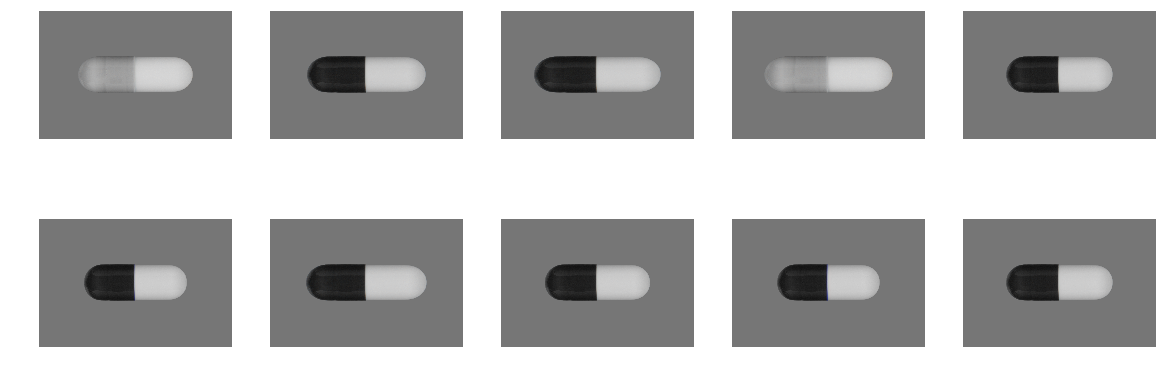

In [15]:
#plots(aug_images, figsize=(20,7), rows=2)